In [286]:
base_url = "..\\experiment(Jupyter)_artifacts\\"
dataset_folder_path = "built_dataset"
train_file_name = "train.csv"
eda_artifacts_folder = "EDA"
pandas_profiling_output_file_path = "output.html"
TARGET_FEATURE = "Time_taken"
useless_features = ['ID', 'Delivery_person_ID']

# Loading the libraries

In [287]:
import os
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# EDA artifacts folder 

In [288]:
eda_artifacts_folder = os.path.join(base_url,eda_artifacts_folder)

In [289]:
os.makedirs(eda_artifacts_folder, exist_ok=True)

# Ingesting train file

In [290]:
train_file_path = os.path.join(base_url,dataset_folder_path,train_file_name)
train_df = pd.read_csv(train_file_path)

In [291]:
train_df.drop(useless_features,axis = 1, inplace= True)

# Pandas Profiling

In [7]:
profile = ProfileReport(train_df,title = 'EDA Report', explorative=True, dark_mode=True)


In [8]:
profile.to_file(os.path.join(eda_artifacts_folder,pandas_profiling_output_file_path))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# DTALE

In [9]:
import dtale

In [10]:
dtale.show(train_df)

# Self EDA

## Agenda

1. Missing Values
2. All numerical variables
3. Temporal Features
4. Distribution of numerical variables
5. Categorical Features
6. Outliers
7. Relationship b/w Independant and Dependant Features

#### Missing Values

In [292]:
train_df.isnull().sum()

Delivery_person_Age            1504
Delivery_person_Ratings        1546
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1409
Time_Order_picked                 0
Weather                         492
Road_traffic_density            482
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             792
Festival                        187
City                            958
Time_taken                        0
dtype: int64

In [12]:
missing_values_features = [feature for feature in train_df.columns if train_df[feature].isnull().sum()>=1]

In [13]:
missing_values_features

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Time_Orderd',
 'Weather',
 'Road_traffic_density',
 'multiple_deliveries',
 'Festival',
 'City']

In [14]:
for feature in missing_values_features:
    print(f" Feature {feature} has {np.round((train_df[feature].isnull().mean())*100,4)} % missing values")

 Feature Delivery_person_Age has 4.1235 % missing values
 Feature Delivery_person_Ratings has 4.2386 % missing values
 Feature Time_Orderd has 3.863 % missing values
 Feature Weather has 1.3489 % missing values
 Feature Road_traffic_density has 1.3215 % missing values
 Feature multiple_deliveries has 2.1714 % missing values
 Feature Festival has 0.5127 % missing values
 Feature City has 2.6265 % missing values


In [15]:
train_df.shape

(36474, 18)

#### Checking Outliers in Independant features

<ipython-input-16-f77e2eb5d57e>:2: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.

2022-08-27 21:36:01,305 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


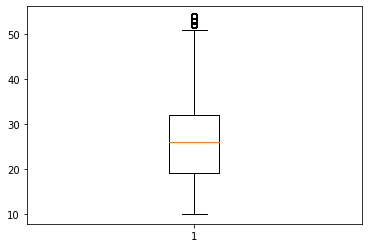

In [16]:
plt.boxplot(train_df[TARGET_FEATURE])
plt.show()

In [17]:
## There are outliers in Independant feature so will use median for analysis

### Relationship b/w missing values and Independant feature (Time taken)

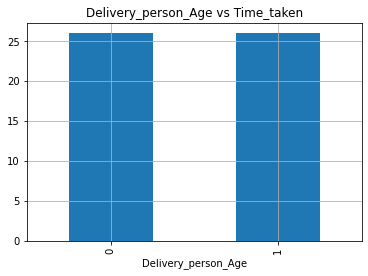

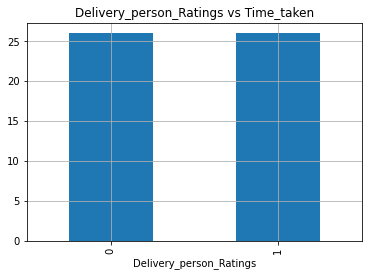

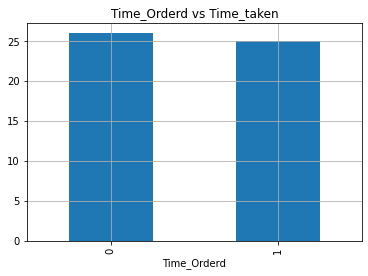

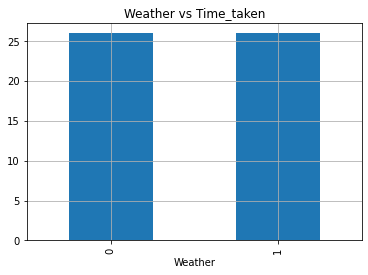

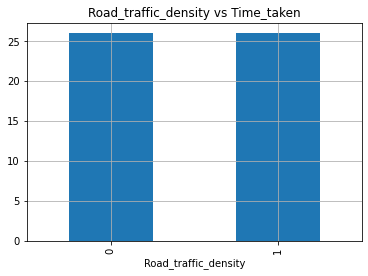

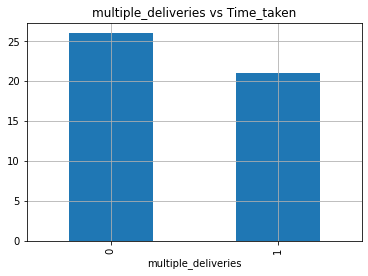

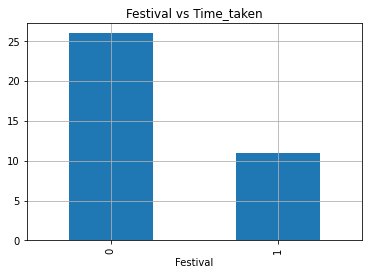

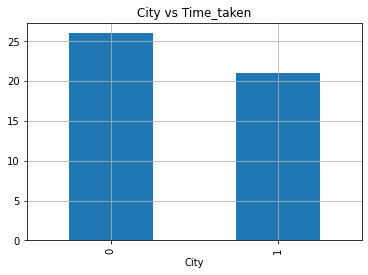

In [23]:
data = train_df.copy()
for feature in missing_values_features:
    ## Let's create a feature where value is 1 if its a missing value and 0 if otherwise
    
    data[feature]  = np.where(data[feature].isnull(),1,0)
    
    ## Median of Time Taken where data is missing or not missing
    data.groupby(feature)[TARGET_FEATURE].median().plot.bar()
    plt.title(f"{feature} vs {TARGET_FEATURE}")
    plt.grid()
    plt.show()
    

### Observations

1. <strong>Delivery Person Age, Delivery Person Ratings, Time Ordered, Weather, Road Traffic Density</strong> are thos features where there is no difference on Time Taken if feature is missing or not. We can even drop these datapoints as there is no pattern to be captured. We probably won't as in real life, these missing values can be problematic.

2. <strong>Multiple Deliveries, Festival, City</strong> are those features where there is a relationship if the value is missing or not missing. These datapoints should not be dropped. We need to impute them with something useful

## Seperating Numerical and Categorical Features

In [24]:
numerical_features = [feature for feature in train_df.columns if train_df[feature].dtypes !='object']

In [25]:
numerical_features

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Vehicle_condition',
 'multiple_deliveries',
 'Time_taken']

In [43]:
categorical_features = set(train_df.columns) - set(numerical_features)

In [44]:
categorical_features = list(categorical_features)

In [45]:
categorical_features 

['Time_Order_picked',
 'Order_Date',
 'Road_traffic_density',
 'Weather',
 'Type_of_order',
 'Type_of_vehicle',
 'Time_Orderd',
 'City',
 'Festival']

## Temporal Features

The time based independant features are:

1. Order_date
2. Time Order picked
3. Time ordered


In [168]:
temporal_features = ['Order_Date','Time_Order_picked','Time_Orderd']

In [163]:
### These are in categorical features so let's drop these from categorical features list

categorical_features = [feature for feature in categorical_features if feature not in set(temporal_features)]


### Working on Order_date

In [169]:
temporal_features_with_dependant_feature = temporal_features.copy()
temporal_features_with_dependant_feature.append(TARGET_FEATURE)
data = train_df[temporal_features_with_dependant_feature].copy()
data['Order_Day'] = data['Order_Date'].str.split('-').str[0].astype(int)
data['Order_Month'] = data['Order_Date'].str.split('-').str[1].astype(int)
data['Order-Year'] = data['Order_Date'].str.split('-').str[2].astype(int)

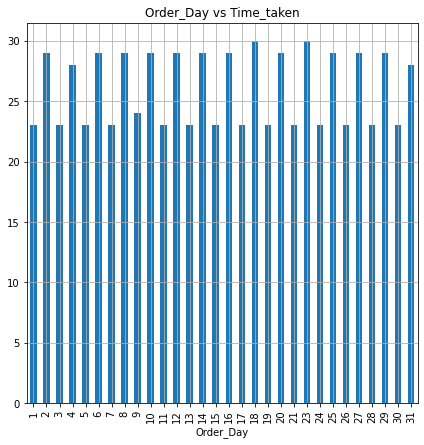

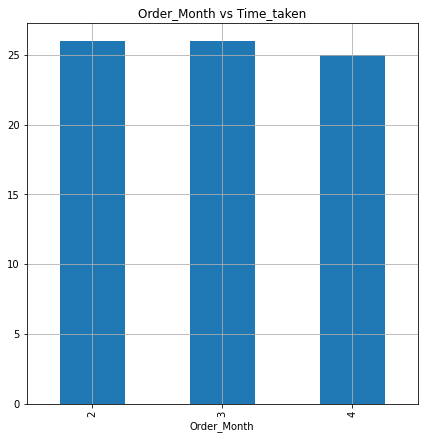

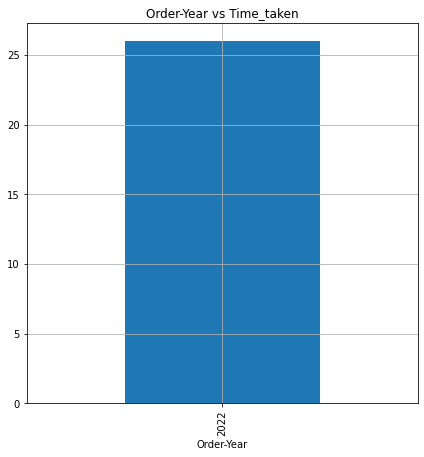

In [172]:
for feature in ['Order_Day', 'Order_Month' , 'Order-Year']:
    plt.figure(figsize=(7,7))
    data.groupby(feature)[TARGET_FEATURE].median().plot.bar()
    plt.grid()
    plt.title(f"{feature} vs {TARGET_FEATURE}")
    plt.show()

#### Observations:

1. Order-Month and Order-Year are uniform, there seems to be no pattern

2. <strong>Order Day has very peculiar pattern, every alternate day, the time taken increases</strong>

### Working on Time Ordered

In [189]:
temporal_features_with_dependant_feature = temporal_features.copy()
temporal_features_with_dependant_feature.append(TARGET_FEATURE)
data = train_df[temporal_features_with_dependant_feature].copy()
data.drop(data[data['Time_Orderd'].isna()].index, inplace=True)
data['Time_Ordered_Hr'] = data['Time_Orderd'].str.split(':').str[0].astype(int)
data['Time_Ordered_Min'] = data['Time_Orderd'].str.split(':').str[1].astype(int)

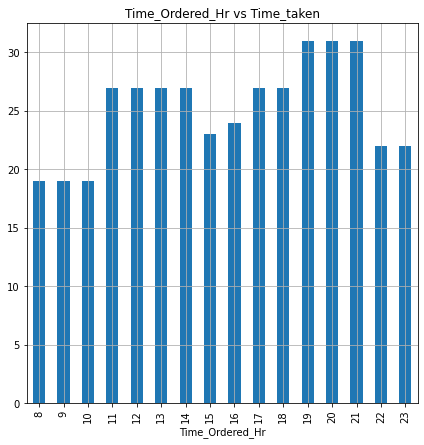

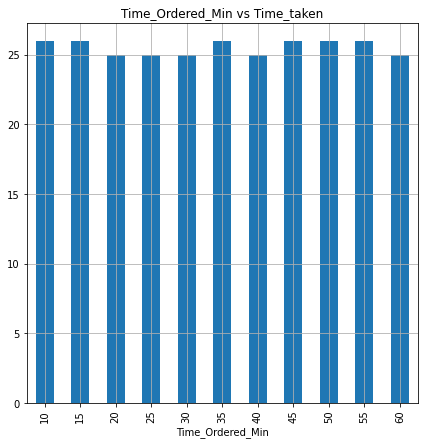

In [190]:
for feature in ['Time_Ordered_Hr', 'Time_Ordered_Min']:
    plt.figure(figsize=(7,7))
    data.groupby(feature)[TARGET_FEATURE].median().plot.bar()
    plt.grid()
    plt.title(f"{feature} vs {TARGET_FEATURE}")
    plt.show()

### Observations:

1. Time_Ordered_Min :  Has uniform distribution so not a useful feature

2. Time_Ordered_Hr = <strong>Important Feature</strong>, Time taken increases around afternoon (Lunch Time)(From 11 AM to 2 PM) and evening ( From 5 PM to 9 PM)

### Working on Time_Ordered_Picked

This will have a high correlation with Time_Ordered Feature so the analysis remains same. But we can use this feature to know the relationship b.w. Time Required to pick the order and eventual Time Taken

In [271]:
temporal_features_with_dependant_feature = temporal_features.copy()
temporal_features_with_dependant_feature.append(TARGET_FEATURE)
data = train_df[temporal_features_with_dependant_feature].copy()
data.drop(data[data['Time_Orderd'].isna()].index, inplace=True)

In [272]:
data['Time_Ordered_Hr'] = data['Time_Orderd'].str.split(":").str[0].astype(int)

In [273]:
data['Time_Ordered_Min'] = data['Time_Orderd'].str.split(":").str[1].astype(int)
data['Time_Picked_Hr'] = data['Time_Order_picked'].str.split(":").str[0].astype(int)
data['Time_Picked_Min'] = data['Time_Order_picked'].str.split(":").str[1].astype(int)

In [274]:
## Calculating time delta b.w Order picked and Order placed
data['Time_bw_Picked_Ordered'] = 60*(data['Time_Picked_Hr'] - data['Time_Ordered_Hr']) + (data['Time_Picked_Min'] - data['Time_Ordered_Min'])

In [275]:
#### Dropping intermediate features
data.drop(['Time_Ordered_Hr','Time_Ordered_Min','Time_Picked_Hr','Time_Picked_Min'],axis = 1, inplace=True)

#### Let's see relation b.w. this difference and Target Feature

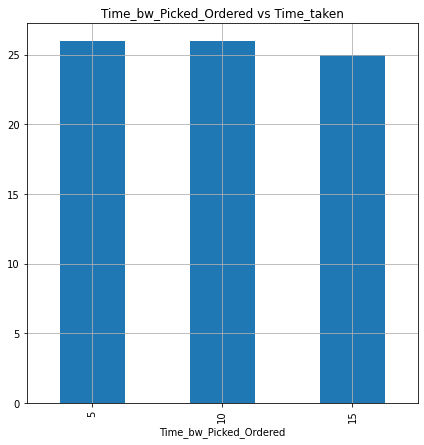

In [277]:
for feature in ['Time_bw_Picked_Ordered']:
    plt.figure(figsize=(7,7))
    data.groupby(feature)[TARGET_FEATURE].median().plot.bar()
    plt.grid()
    plt.title(f"{feature} vs {TARGET_FEATURE}")
    plt.show()

### Observations:

1. All the deliveries get picked within 15 minutes of order.

2. Distribution of  "Difference b.w. Time Picked and Time Ordered   vs  Time taken" is uniform so this is not a good feature

3. <strong> There are missing values in Time Ordered. There will be huge correlation of Time Ordered with Time Ordered Picked. We can drop Time Ordered and simply use Time Ordered Picked for analysis </strong> 

In [293]:
data['Time_Ordered_Hr'] = data['Time_Orderd'].str.split(":").str[0].astype(int)
data['Time_Picked_Hr'] = data['Time_Order_picked'].str.split(":").str[0].astype(int)

In [295]:
np.corrcoef(data['Time_Ordered_Hr'], data['Time_Picked_Hr'])

array([[1.        , 0.99636545],
       [0.99636545, 1.        ]])

#### There is 99 % correlation. We only need one of these features. As there are missing values in Time Ordered, we can simply drop Time Ordered and use Time Ordered Picked